# NGSolve Model Templates: 

A python library on top of NGSolve providing state of the art numerical methods for many equations.

## Navier Stokes

hybrid mixed method for Navier-Stokes (Gopalakrishnan+Lederer+Schöberl '20,'20), Dissertation Lederer 2019

In [1]:
from ngsolve import *
import netgen.geom2d
import netgen.meshing
from ngsolve.webgui import Draw
import ipywidgets as widgets

from ngs_templates.NavierStokes import *
ngsglobals.msg_level = 0

Geometry and mesh:

In [2]:
geo = netgen.geom2d.SplineGeometry()
geo.AddRectangle( (0, 0), (2, 0.41), bcs = ("wall", "outlet", "wall", "inlet"))
geo.AddCircle ( (0.2, 0.2), r=0.05, leftdomain=0, rightdomain=1, bc="cyl", maxh=0.02)
mesh = Mesh( geo.GenerateMesh(maxh=0.07))
Draw (mesh)
mesh.Curve(3);

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

In [3]:
timestep = 0.001
navstokes = NavierStokes (mesh, nu=0.001, order=4, timestep = timestep,
                              inflow="inlet", outflow="outlet", wall="wall|cyl",
                              uin=CoefficientFunction( (1.5*4*y*(0.41-y)/(0.41*0.41), 0) ))
                              

navstokes.SolveInitial()

In [4]:

scene = Draw (Norm(navstokes.velocity), mesh, "velocity")
tw = widgets.Text(value='t = 0')
display(tw)

tend = 5
t = 0
cnt = 0
with TaskManager():
    while t < tend:
        navstokes.DoTimeStep()
        t = t+timestep
        cnt = cnt+1
        if cnt % 100 == 0:
            tw.value = "t = "+str(t)
            scene.Redraw()

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

Text(value='t = 0')

## The code for the MCS - Navier-Stokes solver

* MCS mixed method from [Lederer+Gopalakrishnan+JS,20]
* velocity $u_h \in BDM^k \subset H(\operatorname{div})$ and stress $\sigma_h \in H(\operatorname{div} \operatorname{curl})$
* upwind DG for convetive term
* uses SIMPLE time-stepping
* hybrid mixed system for pressure correction

see https://github.com/NGSolve/modeltemplates

In [ ]:
# raise Exception("This is just for demonstation")

class NavierStokes:
    
    def __init__(self, mesh, nu, inflow, outflow, wall, uin, timestep, order=2, volumeforce=None):

        self.nu = nu
        self.timestep = timestep
        self.uin = uin
        self.inflow = inflow
        self.outflow = outflow
        self.wall = wall
        
        V = HDiv(mesh, order=order, dirichlet=inflow+"|"+wall, RT=False)
        self.V = V
        Vhat = TangentialFacetFESpace(mesh, order=order-1, dirichlet=inflow+"|"+wall+"|"+outflow)
        Sigma = HCurlDiv(mesh, order = order-1, orderinner=order, discontinuous=True)
        if mesh.dim == 2:
            S = L2(mesh, order=order-1)            
        else:
            S = VectorL2(mesh, order=order-1)

        Sigma.SetCouplingType(IntRange(0,Sigma.ndof), COUPLING_TYPE.HIDDEN_DOF)
        Sigma = Compress(Sigma)
        S.SetCouplingType(IntRange(0,S.ndof), COUPLING_TYPE.HIDDEN_DOF)
        S = Compress(S)
        
        self.X = V*Vhat*Sigma*S
        for i in range(self.X.ndof):
            if self.X.CouplingType(i) == COUPLING_TYPE.WIREBASKET_DOF:
                self.X.SetCouplingType(i, COUPLING_TYPE.INTERFACE_DOF)
        # self.v1dofs = self.X.Range(0)
        
        u, uhat, sigma, W  = self.X.TrialFunction()
        v, vhat, tau, R  = self.X.TestFunction()

        if mesh.dim == 2:
            def Skew2Vec(m):
                return m[1,0]-m[0,1]
        else:
            def Skew2Vec(m):   
                return CoefficientFunction( (m[0,1]-m[1,0], m[2,0]-m[0,2], m[1,2]-m[2,1]) )

        dS = dx(element_boundary=True)
        n = specialcf.normal(mesh.dim)
        def tang(u): return u-(u*n)*n
        
        stokesA = -0.5/nu * InnerProduct(sigma,tau) * dx + \
          (div(sigma)*v+div(tau)*u) * dx + \
          (InnerProduct(W,Skew2Vec(tau)) + InnerProduct(R,Skew2Vec(sigma))) * dx + \
          -(((sigma*n)*n) * (v*n) + ((tau*n)*n )* (u*n)) * dS + \
          (-(sigma*n)*tang(vhat) - (tau*n)*tang(uhat)) * dS

        
        self.astokes = BilinearForm (self.X, eliminate_hidden = True)
        self.astokes += stokesA
        self.astokes += 1e12*nu*div(u)*div(v) * dx

        self.a = BilinearForm (self.X, eliminate_hidden = True)
        self.a += stokesA

        self.gfu = GridFunction(self.X)
        self.f = LinearForm(self.X)

        self.mstar = BilinearForm(self.X, eliminate_hidden = True, condense=True)
        self.mstar += u*v * dx + timestep * stokesA

        self.premstar = Preconditioner(self.mstar, "bddc")
        self.mstar.Assemble()
        # self.invmstar = self.mstar.mat.Inverse(self.X.FreeDofs(), inverse="sparsecholesky")
        # self.invmstar1 = self.mstar.mat.Inverse(self.X.FreeDofs(self.mstar.condense), inverse="sparsecholesky")
        
        self.invmstar1 = CGSolver(self.mstar.mat, pre=self.premstar, precision=1e-4, printrates=False)
        ext = IdentityMatrix()+self.mstar.harmonic_extension
        extT = IdentityMatrix()+self.mstar.harmonic_extension_trans
        self.invmstar = ext @ self.invmstar1 @ extT + self.mstar.inner_solve
        
        # the convective term 
        if True:
            u,v = V.TnT()
            self.conv = BilinearForm(V, nonassemble=True)
            self.conv += InnerProduct(grad(v)*u, u).Compile(realcompile=realcompile, wait=True) * dx
            self.conv += (-IfPos(u * n, u*n*u*v, u*n*u.Other(bnd=self.uin)*v)).Compile(realcompile=realcompile, wait=True) * dS
            rest = self.X.Restriction(0)
            self.conv_operator = rest.T @ self.conv.mat @ rest
        else:
            VL2 = VectorL2(mesh, order=order, piola=True)
            ul2,vl2 = VL2.TnT()
            self.conv_l2 = BilinearForm(VL2, nonassemble=True)
            self.conv_l2 += InnerProduct(grad(vl2)*ul2, ul2).Compile(realcompile=realcompile, wait=True) * dx
            self.conv_l2 += (-IfPos(ul2 * n, ul2*n*ul2*vl2, ul2*n*ul2.Other(bnd=self.uin)*vl2)).Compile(realcompile=realcompile, wait=True) * dS
            self.convertl2 = V.ConvertL2Operator(VL2) @ self.X.Restriction(0)
            self.conv_operator = self.convertl2.T @ self.conv_l2.mat @ self.convertl2

        # setup problem for pressure projection (hybrid mixed)
        # self.V2 = Discontinuous(self.V)
        self.V2 = HDiv(mesh, order=order, dirichlet=inflow+"|"+wall, RT=False, discontinuous=True)        
        self.Q = L2(mesh, order=order-1)
        self.Qhat = FacetFESpace(mesh, order=order, dirichlet=outflow)        
        self.Xproj = self.V2*self.Q*self.Qhat
        (u,p,phat),(v,q,qhat) = self.Xproj.TnT()
        aproj = BilinearForm(self.Xproj, condense=True)
        aproj += (-u*v+ div(u)*q + div(v)*p) * dx + (u*n*qhat+v*n*phat) * dS
        # cproj = Preconditioner(aproj, "bddc", coarsetype="h1amg")
        # cproj = Preconditioner(aproj, "bddc")
        # cproj = Preconditioner(aproj, "gamg")
        cproj = Preconditioner(aproj, "bddc", coarsetype="gamg")        
        aproj.Assemble()
        
        # self.invproj1 = aproj.mat.Inverse(self.Xproj.FreeDofs(aproj.condense), inverse="sparsecholesky")
        self.invproj1 = CGSolver(aproj.mat, pre=cproj, printrates=False)
        ext = IdentityMatrix()+aproj.harmonic_extension
        # extT = IdentityMatrix()+aproj.harmonic_extension_trans
        self.invproj = ext @ self.invproj1 @ ext.T + aproj.inner_solve
        
        self.bproj = BilinearForm(div(self.V.TrialFunction())*q*dx).Assemble()

        # mapping of discontinuous to continuous H(div)
        ind = self.V.ndof * [0]
        for el in mesh.Elements(VOL):
            dofs1 = self.V.GetDofNrs(el)
            dofs2 = self.V2.GetDofNrs(el)
            for d1,d2 in zip(dofs1,dofs2):
                ind[d1] = d2
        self.mapV = PermutationMatrix(self.Xproj.ndof, ind)
        
                
    @property
    def velocity(self):
        return self.gfu.components[0]
    @property
    def pressure(self):
        return 1e6/self.nu*div(self.gfu.components[0])
        
    def SolveInitial(self):
        self.a.Assemble()        
        self.f.Assemble()
        
        temp = self.a.mat.CreateColVector()
        self.gfu.components[0].Set (self.uin, definedon=self.X.mesh.Boundaries(self.inflow))
        self.gfu.components[1].Set (self.uin, definedon=self.X.mesh.Boundaries(self.inflow))

        self.astokes.Assemble()
        inv = self.astokes.mat.Inverse(self.X.FreeDofs(), inverse="sparsecholesky")
        temp.data = -self.astokes.mat * self.gfu.vec + self.f.vec
        self.gfu.vec.data += inv * temp

                
    def AddForce(self, force):
        force = CoefficientFunction(force)
        v, vhat, tau, R  = self.X.TestFunction()        
        self.f += force*v*dx
        
    def DoTimeStep(self):
        
        self.temp = self.a.mat.CreateColVector()
        self.temp2 = self.a.mat.CreateRowVector()
        self.f.Assemble()
        
        self.temp.data = self.conv_operator * self.gfu.vec
        self.temp.data += self.f.vec
        self.temp.data += -self.a.mat * self.gfu.vec
        self.temp2.data =  self.invmstar * self.temp
        # self.ProjectFull(self.temp2)
        self.Project(self.temp2[self.X.Range(0)])
        self.gfu.vec.data += self.timestep * self.temp2.data

        
    def Project(self,vel):        
        vel.data -= self.mapV @ self.invproj @ self.bproj.mat * vel

    def ProjectFull(self,vel):
        emb = self.X.Embedding(0)
        rest = self.X.Restriction(0)
        # opinfo = (emb@self.mapV @ self.invproj @ self.bproj.mat@rest).GetOperatorInfo()
        # print ("project operator =", opinfo)
        vel.data -= emb @ self.mapV @ self.invproj @ self.bproj.mat @ rest * vel




Our first flying plane (by Philip Lederer)

<img src="front.png" alt="Alternative text" width="800" align="center"/>

<img src="wing-NSt.png" alt="Alternative text" width="800" align="center"/>
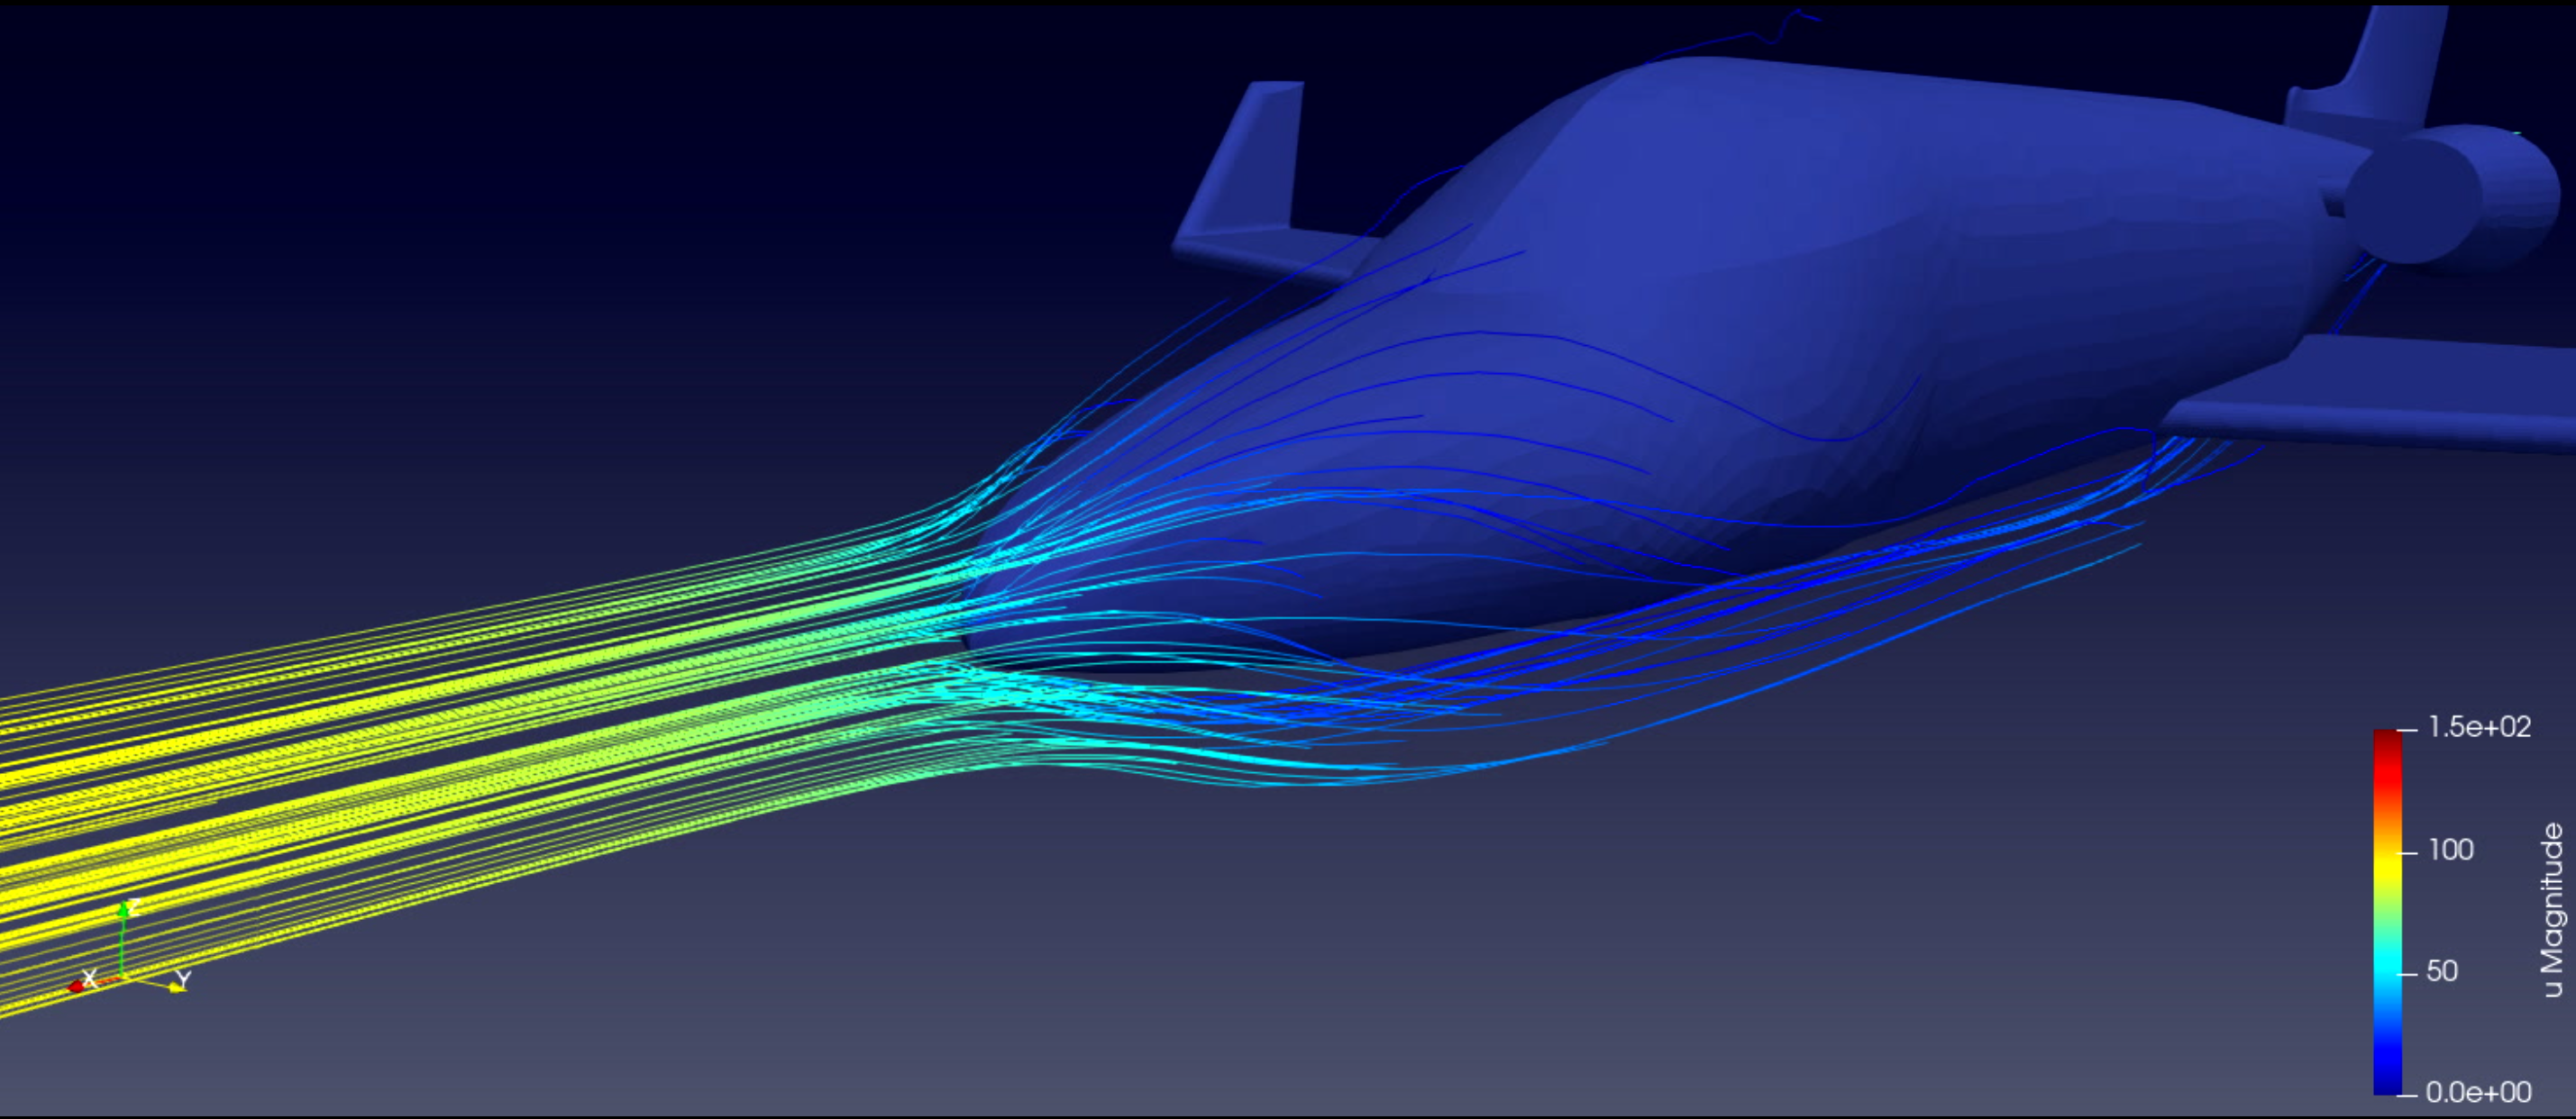